In [1]:
# импортируем программные библиотеки, которые помогут нам работать со спутниковыми данными

# Основное средство - GDAL. Основной компонент работы с растровыми геоданными, который вообще везде
from osgeo import gdal

# matplotlib - самая большая и мощная библиотека визуализации данных в Python
import matplotlib.pyplot as plt
import matplotlib as mpl

# numpy - одна из главных математических библиотек Python. Быстрые вычисления матриц (а снимки - это матрицы)
import numpy as np

# Некоторые служебные команды. Так мы сможем смотреть на изображения прямо в jupyter notebook
from IPython.display import Image

# Настроим размер картинок, которые будет показывать jupyter notebook
mpl.rcParams['figure.figsize'] = (10,10)

In [61]:
#подгрузка вероятностей, землепользования на 1770 и пустого файла для лэнд юза
dataset = gdal.Open('Probability/lu1860.asc')
dataset0 = gdal.Open('Probability/P0.asc')
dataset1 = gdal.Open('Probability/P1.asc')
dataset2 = gdal.Open('Probability/P2.asc')
dataset3 = gdal.Open('Probability/P3.asc')
dataset4 = gdal.Open('Probability/Empty.asc')
dachi_id = gdal.Open('Probability/Drivers/dachi_id.asc').ReadAsArray()

In [117]:
#determining raster size
X=dataset0.RasterXSize
Y=dataset0.RasterYSize

In [63]:
# Матрица чисел
dataset.ReadAsArray()

array([[-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       ...,
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.],
       [-99999., -99999., -99999., ..., -99999., -99999., -99999.]],
      dtype=float32)

In [64]:
LU1860=dataset.ReadAsArray()

In [106]:
#открытие растров
P0=dataset0.ReadAsArray()
P1=dataset1.ReadAsArray()
P2=dataset2.ReadAsArray()
P3=dataset3.ReadAsArray()
LU=dataset4.ReadAsArray()
#ввод E0, E1, E2, E3
iter0=0
iter1=0
iter2=0
iter3=0
count=0
#ввод эластичностей
E0=0.2177815772600983
E1=0.43029512473503995
E2=0.24595155709342562
E3=3.6788990825688074
#добавление эластичностей в пикселях с опр. LU (поощряет сохранение в старых границах)
for i in range(0, Y):
    for j in range(0, X):
        if P0[i][j]!=-99999:
            if LU[i][j]==0:
                P0[i][j]+=E0
            if LU[i][j]==1:
                P1[i][j]+=E1
            if LU[i][j]==2:
                P2[i][j]+=E2
            if LU[i][j]==3:
                P3[i][j]+=E3
            else:
                continue
#по очереди обращаемся к каждой даче с её спросом
dachas=[869, 856, 859, 860, 861, 862, 865, 866, 867, 868, 870, 872, 873, 874, 875, 877, 880, 881, 882]
demands=[0, 0, 0, 0, 0, 0.145, 0.1335, 0, 0, 0.033, 0.1054, 0, 0, 0, 0.078, 0.133, 0, 0.0413, 0]
L=len(dachas)
for N in range(0, L):
    breaker=0
    while breaker==0:
        dachasN=dachas[N]
        for i in range(0, Y):
            for j in range(0, X):
                if dachi_id[i][j]==dachasN:
                    #добавление итерационного параметрa 
                    if P0[i][j]!=-99999:
                        P0[i][j]+=iter0
                        P1[i][j]+=iter1
                        P2[i][j]+=iter2
                        P3[i][j]+=iter3
        #первичное распределение лэнд юза
                    if P0[i][j]!=-99999:
                        PG=max(P0[i][j],P1[i][j],P2[i][j],P3[i][j])
                        if P1[i][j]>=PG:
                            LU[i][j]=1
                        else:
                            LU[i][j]=4
                    else:
                        LU[i][j]=-99999
                    if LU1860[i][j]==5:
                        LU[i][j]=5
        #подсчёт доли пикселей от общего LU
        uses=0
        others=0
        fields=0
        for i in range(0, Y):
            for j in range(0, X):
                if dachi_id[i][j]==dachasN:
                    if P0[i][j]!=-99999:
                        uses+=1
                        if LU[i][j]==1:
                            fields+=1
                        elif LU[i][j]==4:
                            others+=1
        print ('Fields =', fields)
        print ('Others =', others)
        #определение разницы с демандом
        #ввод demand0, demand1, demand2, demand3
        demand1=demands[N]
        diff1=demand1-fields/uses
        #выведем разницы
        print ('diff1 =', diff1)
        check1=0
        if diff1>0.01 or diff1<-0.01: #число из головы (1%)
            if diff1>0.01:
                iter1=diff1*0.5
            else:
                iter1=diff1 #чтобы не получалось одинаковых "перескоков"
        else:
            check1=1
        #находим подходящее распределение
        if check1==1:
            print ('success for region', dachasN)
            breaker=1
        else:
            print ('one more')

Fields = 0
Others = 1244
diff1 = 0.0
success for region 869
Fields = 0
Others = 1591
diff1 = 0.0
success for region 856
Fields = 114
Others = 5079
diff1 = -0.0219526285384171
one more
Fields = 94
Others = 5099
diff1 = -0.018101290198343924
one more
Fields = 75
Others = 5118
diff1 = -0.014442518775274409
one more
Fields = 67
Others = 5126
diff1 = -0.012901983439245137
one more
Fields = 55
Others = 5138
diff1 = -0.010591180435201233
one more
Fields = 48
Others = 5145
diff1 = -0.00924321201617562
success for region 859
Fields = 0
Others = 1686
diff1 = 0.0
success for region 860
Fields = 0
Others = 1619
diff1 = 0.0
success for region 861
Fields = 874
Others = 20238
diff1 = 0.1036017430845017
one more
Fields = 1152
Others = 19960
diff1 = 0.09043387646835921
one more
Fields = 1397
Others = 19715
diff1 = 0.0788291019325502
one more
Fields = 1611
Others = 19501
diff1 = 0.06869268662372109
one more
Fields = 1844
Others = 19268
diff1 = 0.05765630920803333
one more
Fields = 2012
Others = 19100
di

Fields = 28
Others = 1209
diff1 = 0.08276459175424414
one more
Fields = 28
Others = 1209
diff1 = 0.08276459175424414
one more
Fields = 29
Others = 1208
diff1 = 0.0819561843168957
one more
Fields = 29
Others = 1208
diff1 = 0.0819561843168957
one more
Fields = 29
Others = 1208
diff1 = 0.0819561843168957
one more
Fields = 29
Others = 1208
diff1 = 0.0819561843168957
one more
Fields = 29
Others = 1208
diff1 = 0.0819561843168957
one more
Fields = 42
Others = 1195
diff1 = 0.0714468876313662
one more
Fields = 109
Others = 1128
diff1 = 0.017283589329021826
one more
Fields = 121
Others = 1116
diff1 = 0.007582700080840735
success for region 870
Fields = 0
Others = 3997
diff1 = 0.0
success for region 872
Fields = 0
Others = 5931
diff1 = 0.0
success for region 873
Fields = 0
Others = 8219
diff1 = 0.0
success for region 874
Fields = 105
Others = 6282
diff1 = 0.06156035697510569
one more
Fields = 153
Others = 6234
diff1 = 0.054045091592296854
one more
Fields = 205
Others = 6182
diff1 = 0.045903554094

In [110]:
#Если что-то доделать надо (маленький регион, однородное поле вероятности)
dachas=[871]
demands=[0.2085]
L=len(dachas)
for N in range(0, L):
    breaker=0
    while breaker==0:
        dachasN=dachas[N]
        for i in range(0, Y):
            for j in range(0, X):
                if dachi_id[i][j]==dachasN:
                    #добавление итерационного параметрa 
                    if P0[i][j]!=-99999:
                        P0[i][j]+=iter0
                        P1[i][j]+=iter1
                        P2[i][j]+=iter2
                        P3[i][j]+=iter3
        #первичное распределение лэнд юза
                    if P0[i][j]!=-99999:
                        PG=max(P0[i][j],P1[i][j],P2[i][j],P3[i][j])
                        if P1[i][j]>=PG:
                            LU[i][j]=1
                        else:
                            LU[i][j]=4
                    else:
                        LU[i][j]=-99999
                    if LU1860[i][j]==5:
                        LU[i][j]=5
        #подсчёт доли пикселей от общего LU
        uses=0
        others=0
        fields=0
        for i in range(0, Y):
            for j in range(0, X):
                if dachi_id[i][j]==dachasN:
                    if P0[i][j]!=-99999:
                        uses+=1
                        if LU[i][j]==1:
                            fields+=1
                        elif LU[i][j]==4:
                            others+=1
        print ('Fields =', fields)
        print ('Others =', others)
        #определение разницы с демандом
        #ввод demand0, demand1, demand2, demand3
        demand1=demands[N]
        diff1=demand1-fields/uses
        #выведем разницы
        print ('diff1 =', diff1)
        check1=0
        if diff1>0.01 or diff1<-0.01: #число из головы (1%)
            if diff1>0.01:
                iter1=diff1*0.02
            else:
                iter1=diff1*0.2 #чтобы не получалось одинаковых "перескоков"
        else:
            check1=1
        #находим подходящее распределение
        if check1==1:
            print ('success for region', dachasN)
            breaker=1
        else:
            print ('one more')

Fields = 75
Others = 492
diff1 = 0.07622486772486772
one more
Fields = 81
Others = 486
diff1 = 0.06564285714285714
one more
Fields = 82
Others = 485
diff1 = 0.06387918871252204
one more
Fields = 83
Others = 484
diff1 = 0.06211552028218695
one more
Fields = 87
Others = 480
diff1 = 0.05506084656084656
one more
Fields = 88
Others = 479
diff1 = 0.05329717813051146
one more
Fields = 89
Others = 478
diff1 = 0.051533509700176366
one more
Fields = 92
Others = 475
diff1 = 0.046242504409171076
one more
Fields = 94
Others = 473
diff1 = 0.04271516754850088
one more
Fields = 95
Others = 472
diff1 = 0.040951499118165785
one more
Fields = 99
Others = 468
diff1 = 0.0338968253968254
one more
Fields = 100
Others = 467
diff1 = 0.0321331569664903
one more
Fields = 101
Others = 466
diff1 = 0.030369488536155204
one more
Fields = 102
Others = 465
diff1 = 0.028605820105820107
one more
Fields = 104
Others = 463
diff1 = 0.025078483245149913
one more
Fields = 104
Others = 463
diff1 = 0.025078483245149913
one mor

In [123]:
#импорт созданного грида (без привязки!)
#координаты добавлены вручную
np.savetxt('C:/Users/olegz/Desktop/CLUE/White Lake project/Predicted/Predicted_by_dacha.asc', LU, fmt='%4.1f', comments='', header='NCOLS %s \nNROWS %s \nXLLCORNER 569875.0000000000 \nYLLCORNER 6120445.0000000000 \nCELLSIZE 30.000000 \nNODATA_VALUE -99999.0'%(X, Y))

In [19]:
#подготовка к быстрой визуализации в Питоне
#убираем nodata
Dachi = gdal.Open('C:/Users/olegz/Desktop/CLUE/White Lake project/Predicted/Predicted_by_dacha.asc').ReadAsArray()
Dachi[Dachi == -99999.] = np.nan

In [21]:
dataset18 = gdal.Open('Probability/Predicted16.asc')
General=dataset18.ReadAsArray()
Full_time = gdal.Open('C:/Users/olegz/Desktop/CLUE/White Lake project/Predicted/Predicted_full-time_arable.asc').ReadAsArray()
Full_time[Full_time == -99999.] = np.nan
General[General == -99999.] = np.nan

(-0.5, 505.5, 522.5, -0.5)

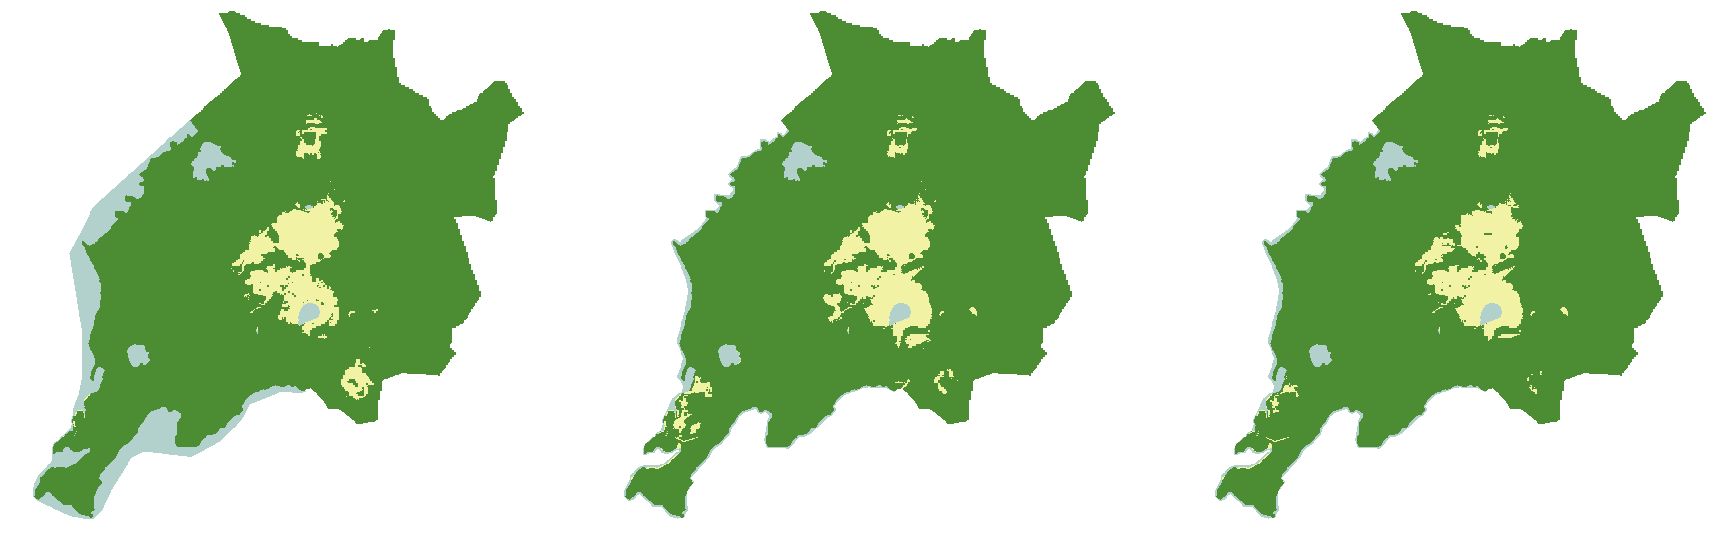

In [24]:
C=[[0.95, 0.95, 0.65],[0.65, 0.9, 0.3],[0.3, 0.55, 0.2], [0.3, 0.55, 0.2], [0.7, 0.82, 0.8]]
cm = mpl.colors.ListedColormap(C)
mpl.rcParams['figure.figsize'] = (30, 30)

plt.subplot(231)
plt.imshow(General, cmap=cm)
plt.axis('off')

plt.subplot(232)
plt.imshow(Dachi, cmap=cm)
plt.axis('off')

plt.subplot(233)
plt.imshow(Full_time, cmap=cm)
plt.axis('off')